读取clinvar数据

In [26]:
import pandas as pd

file_path = r'D:\data\clinvar\variant_summary.txt\variant_summary.txt'
df = pd.read_csv(file_path, delimiter='\t')

E:\Envs\variant_transformer\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df.columns

In [ ]:
df['ClinicalSignificance'].value_counts()[:10]

In [27]:
pathogenicity_levels = ['Benign', 'Benign/Likely benign', 'Likely benign', 'Likely pathogenic', 'Pathogenic']
variants_by_pathogenicity = []
for patho in pathogenicity_levels:
    print(patho)
    variants_by_pathogenicity.append(df['ClinicalSignificance'].value_counts()[patho])
variants_by_pathogenicity

Benign
Benign/Likely benign
Likely benign
Likely pathogenic
Pathogenic


[379155, 51860, 548257, 95178, 217073]

In [ ]:
df['Chromosome'].value_counts()

In [28]:
chrs = [str(i) for i in range(1, 23)]
variants_chr_counts = df['Chromosome'].value_counts()
chrs.extend(['X', 'Y', 'MT'])
variants_by_chr = []
for chr in chrs:
    print(chr)
    variants_by_chr.append(variants_chr_counts[chr])
variants_by_chr

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
X
Y
MT


[172878,
 184241,
 86578,
 50933,
 84275,
 71419,
 77690,
 53699,
 74384,
 59665,
 93838,
 70102,
 47456,
 50839,
 65360,
 109678,
 143403,
 36458,
 97886,
 38425,
 24534,
 43878,
 100408,
 1953,
 5688]

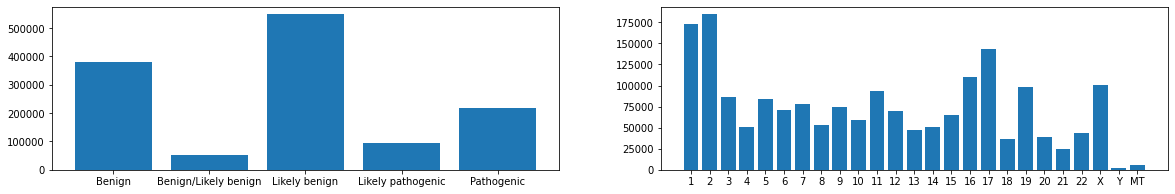

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 3))
plt.subplot(121)
plt.bar(pathogenicity_levels, variants_by_pathogenicity)
plt.subplot(122)
plt.bar(chrs, variants_by_chr)
plt.savefig('../img/data_desc/raw_data_description.png')
plt.show()

In [ ]:
df['Type'].value_counts()

In [ ]:
import pandas as pd

file_path = r'D:\data\clinvar\variant_summary.txt\variant_summary.txt'
df = pd.read_csv(file_path, delimiter='\t')
df = df[df['Type']=='single nucleotide variant']
df = df[(df['ClinicalSignificance'] == 'Pathogenic') | (df['ClinicalSignificance'] == 'Benign')]
df = df[df['Assembly'] == 'GRCh38']
df = df[df['Chromosome']!='MT']
df.to_csv('../data/variants.csv', index=False)

In [ ]:
df['PhenotypeList'].value_counts()

In [ ]:
df[['Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF']]

获取突变位点周围序列

In [ ]:
import pandas as pd

# 取突变位点周围50bp的内容
surrounding_len = 50
df = pd.read_csv('../data/variants.csv')
df['seq_101_ref'] = ''
df['seq_101_alt'] = ''
for chr, subset in df.groupby('Chromosome'):
    print(chr)
    with open(r'D:\data\ucsc\hg38\chr{}.txt'.format(chr)) as f:
        seq = f.readline()
        for index, variant in subset.iterrows():
            point_index = int(variant['PositionVCF'])
            # point_index = seq[point_index-1]
            ref = variant['ReferenceAlleleVCF']
            alt = variant['AlternateAlleleVCF']
            left = seq[point_index-1-surrounding_len:point_index-1]
            right = seq[point_index: point_index+50]
            # print(point_index, ref, alt, seq[point_index-1], left, right)
            if len(left)<50:
                left = 'N' *(50-len(left)) + left
            if len(right)<50:
                right = right + 'N'*(50-len(right))
            t1 = ''.join([left, ref, right])
            t2 = ''.join([left, alt, right])
            df.loc[index, 'seq_101_ref'] = t1.upper()
            df.loc[index, 'seq_101_alt'] = t1.upper()

In [ ]:
# df['label'] = 1 if (df['ClinicalSignificance'] == 'Pathogenic') else 0
df['label'] = -1
df['label'][df['ClinicalSignificance'] == 'Pathogenic'] = 1
df['label'][df['ClinicalSignificance'] != 'Pathogenic'] = 0

In [ ]:
df = df[df['ReferenceAlleleVCF'] != 'na']

In [ ]:
df.to_csv('../data/variants_with_seq.csv', index=False)

In [30]:
import pandas as pd

df = pd.read_csv('../data/variants_with_seq.csv')

In [31]:
pathogenicity_levels = ['Benign', 'Pathogenic']
variants_by_pathogenicity = []
for patho in pathogenicity_levels:
    print(patho)
    variants_by_pathogenicity.append(df['ClinicalSignificance'].value_counts()[patho])
variants_by_pathogenicity

Benign
Pathogenic


[155863, 51331]

In [32]:
chrs = [str(i) for i in range(1, 23)]
variants_chr_counts = df['Chromosome'].value_counts()
chrs.extend(['X', 'Y'])
variants_by_chr = []
for chr in chrs:
    variants_by_chr.append(variants_chr_counts[chr])
variants_by_chr

[17492,
 16962,
 11092,
 7104,
 10109,
 9502,
 9779,
 6850,
 9107,
 8341,
 11211,
 10422,
 4916,
 6011,
 7771,
 9730,
 13058,
 4212,
 9581,
 4718,
 2643,
 4699,
 11711,
 173]

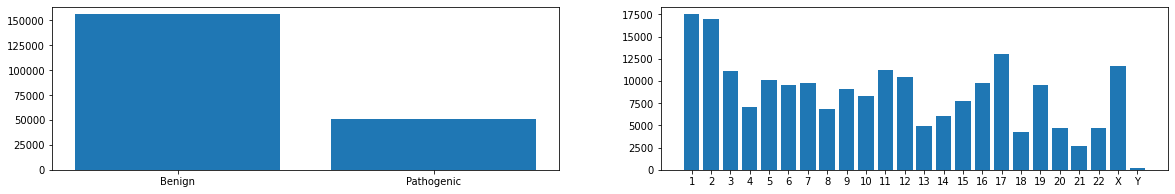

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 3))
plt.subplot(121)
plt.bar(pathogenicity_levels, variants_by_pathogenicity)
plt.subplot(122)
plt.bar(chrs, variants_by_chr)
plt.savefig('../img/data_desc/fliterd_data_description.png')
plt.show()

In [34]:
import pandas as pd

df = pd.read_csv('../data/variants_with_seq.csv')

In [35]:
df_positive = df[df['ClinicalSignificance'] == 'Pathogenic']
df_negative = df[df['ClinicalSignificance'] == 'Benign']

In [47]:
print(df_positive.shape, df_negative.shape)

(51331, 37) (155863, 37)


In [40]:
num_p = df_positive.shape[0]

In [41]:
num_n = df_negative.shape[0]

In [42]:
train_ratio = 0.7
valid_ration = 0.2
test_ration = 0.1

In [45]:
df_positive_train = df_positive.iloc[:int(num_p*train_ratio)]
df_positive_valid = df_positive.iloc[int(num_p*train_ratio):int(num_p*0.9)]
df_positive_test = df_positive.iloc[int(num_p*0.9):]

In [46]:
print(df_positive_train.shape, df_positive_valid.shape, df_positive_test.shape)

(35931, 37) (10266, 37) (5134, 37)


In [48]:
df_negative_train = df_negative.iloc[:int(num_n*train_ratio)]
df_negative_valid = df_negative.iloc[int(num_n*train_ratio):int(num_n*0.9)]
df_negative_test = df_negative.iloc[int(num_n*0.9):]

In [49]:
print(df_negative_train.shape, df_negative_valid.shape, df_negative_test.shape)

(109104, 37) (31172, 37) (15587, 37)


In [51]:
df_train = pd.concat([df_positive_train, df_negative_train])
df_valid = pd.concat([df_positive_valid, df_negative_valid])
df_test = pd.concat([df_positive_test, df_negative_test])

In [52]:
print(df_train.shape, df_valid.shape, df_test.shape)

(145035, 37) (41438, 37) (20721, 37)


In [ ]:
df_train.to_csv('../data/train.csv', index=False)
df_valid.to_csv('../data/valid.csv', index=False)
df_test.to_csv('../data/test.csv', index=False)